### Lasso Estimation verification

In [1]:
import sys
import string
import itertools

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

sys.path.append("..")
import helper.helper as h

from statsmodels.api import OLS
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars

### Generate Data
We generate $\texttt{T}$ samples with a dense weighted adjacency matrix $W$. For simplicity, we do not permute $W$, as this would only switch around some rows and columns.

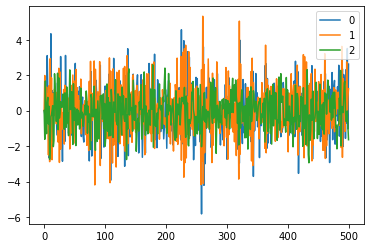

A:
[[ 0.    0.    0.  ]
 [ 0.67 -0.68  0.  ]
 [ 0.   -0.61  0.  ]]

P:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]].

W:
[[ 0.    0.    0.  ]
 [ 0.67 -0.68  0.  ]
 [ 0.   -0.61  0.  ]]


In [2]:
np.random.seed(seed = 123)

## Number of dimensions, number of edges, number of samples
T, n, s = 500, 3, 3

## Coefficient matrix
A_true = h.generate_A(n, s, tril = False, low = 0.5, high = 0.75)

## True permutation
P_true = np.identity(n) # np.random.permutation(np.identity(n))

## True WAM
W_true = P_true.T @ A_true @ P_true

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plots = plt.plot(X);
plt.legend(plots, [i for i in range(n)], loc=1)
plt.show()

# get X value and X prediction
X_val = X[1:]
X_pred = X[:-1]

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.\n\nW:\n{np.round(W_true, 2)}")

Clearly, we see that the plots are stationary. However, there is a significant difference in flutcutation; the blue line ($X_1$) seems to fluctuate much more than the purple line ($X_n$) for example. The reason for this is that $X_n$ only depends on itself. However, $X_1$ depends on all five factors, and all five factors are amplified by a factor between $\texttt{low}$ and $\texttt{high}$. So, although the distribution of $X_1$ is stationary, the variance of $X_1$ is much larger than of $X_n$.

In [3]:
print(f"Covariances of X_1 throught X_{n}.")
for series in X.T:
    print(np.round(np.cov(series), 2), end = ", ")

Covariances of X_1 throught X_3.
2.08, 2.29, 1.02, 

### Lasso Regression
Now, let us consider the LASSO regression. Estimating the parameters that influence the variable $X_i$ means estimating the $ith$ column in the adjacency matrix $W$, or $W_{\cdot, i}$. We do this using LASSO regression, which is of the form
$$\hat{W}_{\cdot, i} = \underset{w}{\arg \min}\left\{X_{[i,\ 1:T]} - X_{[\cdot,\ 0:T-1]} w \right\} + \lambda_{i} \lVert W_{\cdot, i}\rVert_1.$$
The LASSO estimation promotos sparsity of $W_{\cdot, i}$. The larger $\lambda_{i}$, the sparser out solution $\hat{W}_{\cdot, i}$ will be. We apply this LASSO regression on each variable $X_i$, $i = 1, \cdots, n$, which yields $n$ columns $\hat{W}_{\cdot, i}$. Concatenating those estimated yields our estimated matrix $\hat{W}$.

Methods:
1. ``OLS.fit_regularized`` with the ``elatic_net`` method with ``L1_wt = 1.0``.
2. ``Lasso`` [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
2. ``LassoLars`` [LassoLars](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLars.html)

In [4]:
def rls_W(X, alphas, method = "Lasso"):
    
    # get regressor and varibles
    y = X[1:]
    x = X[:-1]

    # initialize W
    W_hat = np.array([])
    
    # for each row, we get the parameters
    for i in range(n):
        
        if method == "OLS_Lasso":
            # OLS Elastic net lasso method
            W_hat = np.append(W_hat, OLS(y[:, i], x).fit_regularized(alpha = alphas[i], L1_wt = 1.0).params)
        elif method == "Lasso":
            # Lasso method
            rls = Lasso(alpha = alphas[i], normalize=False)
            W_hat = np.append(W_hat, rls.fit(x, y[:, i]).coef_)
        elif method == "LassoLars":
            # Lasso method with LARS
            rls = LassoLars(alpha = alphas[i], normalize=False)
            W_hat = np.append(W_hat, rls.fit(x, y[:, i]).coef_)
    
    # rows should be columns
    W_hat = W_hat.reshape((n, n)).T
    
    # return W
    return W_hat

# try for a fixed lambda for all three methods, most likely not a DAG
print(rls_W(X, [0.1] * n, method = "Lasso"))
print(rls_W(X, [0.1] * n, method = "LassoLars"))
print(rls_W(X, [0.1] * n, method = "OLS_Lasso"))

[[-0.          0.0486091   0.        ]
 [ 0.64616596 -0.61336191  0.        ]
 [-0.         -0.51497944 -0.        ]]
[[ 0.          0.04860599  0.        ]
 [ 0.64616596 -0.6133632   0.        ]
 [ 0.         -0.51497929  0.        ]]
[[ 0.          0.04864584  0.        ]
 [ 0.64624266 -0.61332803  0.        ]
 [ 0.         -0.51512746  0.        ]]



#### Values for $\lambda_i$
As is central in this thesis, we are looking for a matrix $\hat{W}$ such that $G(\hat{W})$ is a directed acyclic graph. As mentioned before, the larger the value of $\lambda_i$, the sparser our solution matrix will be. Hence, for large enough $\lambda_i$, we can guarantee that $G(\hat{W})$ is a DAG. However, we do not want a solution where a large number of the true parameters have vanished due to the values for $\lambda_i$ being too large. 

We proceed as follows: we set all $\lambda_i$ to be equal, so $\lambda_i = \lambda$ for all $i = 1, \cdots, n$. Now, we are looking for the smallest value for $\lambda$ such that our estimated $\hat{W}$ yields a directed graph $G(\hat{W})$. In mathematical notation, let

$$\hat{W} = \begin{pmatrix} \hat{W}_{\cdot, 1} & \hat{W}_{\cdot, 2} & \cdots & \hat{W}_{\cdot, n}\end{pmatrix},$$
where $$\hat{W}_{\cdot, i} = \underset{w}{\arg \min}\left\{X_{[i,\ 1:T]} - X_{[\cdot,\ 0:T-1]} w  + \lambda \lVert w\right\}\rVert_1.$$
Then, we have that
$$\lambda_{min} = \min\left\{\lambda \in \mathbb{R}_{\geq 0}\ \big|\ \text{$G(\hat{W})$ is a DAG} \right\}.$$

One valid concern here is that we use the $\textit{same}$ value for all $\lambda_i$. It could very well be that for e.g. $n = 3$, we reach a DAG for $\lambda_1 = 0.1$, $\lambda_2 = 0.25$, $\lambda_3 = 0.15$. In our case, it could very well be that we only get a DAG for $\lambda = 0.25$ (or lower in some scenarios). However, a more principled approach would require to know which $\lambda_i$ to increase. However, this is not clear beforehand. If $G(\hat{W})$ is not a DAG, then there exists a circle. In fact, every edge in this cycle is an equally violating edge. Therefore, for which variable $X_i$ should be increase the penalty parameter $\lambda_i$ then? 

To circumvent this question for now, we simply pick all $\lambda_i$ equal.

In [5]:
def get_W_0(X, method = "Lasso"):

    # initial L1 penalty
    alpha = 0.0
    
    # get W_hat with this penalty
    # we pick an ever so slightly smaller value to circumvent warnings
    # note that we do [] * n, such that all lambdas are equal
    W_hat = rls_W(X, [0.001] * n)
    
    # while W is not a dag
    while not is_dag(W_hat):
        # we increase alpha and try again
        alpha += 0.005
        W_hat = rls_W(X, [alpha] * n, method)

    # report smallest alpha
    print(f"Smallest alpha for DAG: {round(alpha, 2)}.")
    
    # return W and the order
    return W_hat, is_dag(W_hat)[1]

In [6]:
# get W with DAG for all three methods, most likely very comparable
print(np.round(get_W_0(X, method = "Lasso")[0], 2))
print(np.round(get_W_0(X, method = "LassoLars")[0], 2))
print(np.round(get_W_0(X, method = "OLS_Lasso")[0], 2))

NameError: name 'is_dag' is not defined

### Method Evaluation
For sparse matrices, the method seems to work well. First of all, all three Lasso approaches yield approximately the same results. However, let us now see a denser matrix.

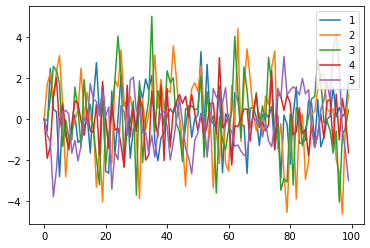

W:
[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.68  0.    0.    0.  ]
 [-0.61  0.   -0.75  0.    0.  ]
 [ 0.   -0.62 -0.67  0.    0.64]]


In [7]:
np.random.seed(seed = 123)

## Number of dimensions, number of edges, number of samples
T, n, s = 100, 5, 6

## Coefficient matrix
W_true = h.generate_A(n, s, tril = False, low = 0.50, high = 0.75)

P_true = np.identity(n)

np.fill_diagonal(W_true, np.abs(np.diagonal(W_true)))
                 
## Generate series
X = h.generate_var_2(T, n, W_true, P_true)

# Plot
plots = plt.plot(X);
plt.legend(plots, [i + 1 for i in range(n)], loc=1)
plt.show()

# get X value and X prediction
X_val, X_pred = X[1:], X[:-1]

print(f"W:\n{np.round(W_true, 2)}")

In [8]:
print(f"Covariances of X_1 throught X_{n}.")
for series in X.T:
    print(np.round(np.cov(series), 2), end = ", ")

Covariances of X_1 throught X_5.
1.67, 3.73, 2.98, 1.18, 2.06, 

In [9]:
print(np.round(get_W_0(X, method = "Lasso")[0], 2))
print(np.round(get_W_0(X, method = "LassoLars")[0], 2))
#print(np.round(get_W_0(X, method = "OLS_Lasso")[0], 2))

NameError: name 'is_dag' is not defined

The above is clearly $\textit{not}$ what we want. The true parameters together formed a lower triangular matrix. However, ours does not resemble that. We miss three true edges, and still have one false edge in our estimate for $W$. The reason fir this is that the variances of each stream are vastly different.
### Fix 1: Rescale all $X_i$ such that $\mathbb{V}(X_i) = 1$ for all $i = 1, ..., n.$

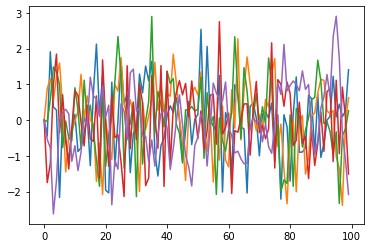

In [10]:
def normalize_data(X):
    data = X.copy()
    
    for i in range(n):
        data[:,i] /= np.sqrt(np.cov(X[:,i]))
        
    return data

X_norm = normalize_data(X)
plt.plot(X_norm);

In [11]:
print(rls_W(X_norm, [0.24] * n, method = "Lasso"))
print(rls_W(X_norm, [0.24] * n, method = "LassoLars"))
print(rls_W(X_norm, [0.24] * n, method = "OLS_Lasso"))

[[ 0.          0.         -0.         -0.         -0.        ]
 [ 0.          0.          0.         -0.          0.        ]
 [-0.          0.45574662  0.         -0.         -0.        ]
 [-0.27615111  0.         -0.1864969  -0.          0.        ]
 [-0.         -0.19048244 -0.36547736  0.          0.3881446 ]]
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.45574397  0.          0.          0.        ]
 [-0.27615111  0.         -0.1864969   0.          0.        ]
 [ 0.         -0.19048368 -0.36547736  0.          0.3881446 ]]
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.45643476  0.          0.          0.        ]
 [-0.27536373  0.         -0.18720479  0.          0.        ]
 [ 0.         -0.19144655 -0.36724379  0.          0.39139736]]


In [12]:
print(f"Covariances of X_1 throught X_{n}.")
for series in X_norm.T:
    print(np.round(np.cov(series), 2), end = ", ")
print("\n")

print(np.round(get_W_0(X_norm, method = "Lasso")[0], 5), end = "\n\n")
print(np.round(get_W_0(X_norm, method = "LassoLars")[0], 5), end = "\n\n")
print(np.round(get_W_0(X_norm, method = "OLS_Lasso")[0], 5))

Covariances of X_1 throught X_5.
1.0, 1.0, 1.0, 1.0, 1.0, 



NameError: name 'is_dag' is not defined

We see that the performance is already much better. Instead of missing three edges, now only one edge is missed. Furthermore, instead of reporting one false edge, we now report zero false edges. It seems that normalizing the data before has a significant improvement on the estimation. 

The reason for this is that when one variable $X_i$ attains much larger values, the loss is minimized by setting the corresponding coefficients of the other variables to non-zero. As these coefficients were zero in the underlying model, we can expect these values to be very small initially, in the order of hundreds. However, these very small coefficients cause the loss to decrease, even more than the actual true coefficients. 

As an example, suppose that we have a variable $X_j$ that attains values ten times as large as variable $X_i$, and there is no true underlying edge from $X_i$ to $X_j$. In practice, for a finite sample, there will be a small non-zero coefficient $w_{ij}$ that helps in minimizing the loss. However, as there is a large difference in attained values, this small coefficient can result in a quite significant decrease in the loss function. In fact, this small coefficient can even result in a larger decrease than a larger "true" coefficient. From a minimization perspective, it is more preferable to remove the larger true coefficient than the smaller incorrect coefficient due to this difference in attained values.

Additional question: Why does normalizing w.r.t. variances help, but translating one series does not seem to cause problems?
### Fix 2: Scale each $\lambda_i$ by their variance $\mathbb{V}(X_i)$.

In [13]:
def get_W_0_rescale_by_covs(X, method = "Lasso"):
    # initial L1 penalty
    alpha = 0.0
    
    stds = np.array([1 / np.std(Xi) for Xi in X.T])
    print(stds)
    # get W_hat with this penalty
    W_hat = rls_W(X, 0.001 * stds, method)
    
    while not is_dag(W_hat):
        alpha += 0.01
        W_hat = rls_W(X, stds * alpha, method)

    print(f"Smallest alpha for DAG: {round(alpha, 2)}.")
    return W_hat, is_dag(W_hat)[1]

print(np.round(get_W_0_rescale_by_covs(X, method = "Lasso")[0], 5), end = "\n\n")
print(np.round(get_W_0_rescale_by_covs(X, method = "LassoLars")[0], 5), end = "\n\n")
print(np.round(get_W_0_rescale_by_covs(X, method = "OLS_Lasso")[0], 5))

[0.77843619 0.52031859 0.58253185 0.92546264 0.69983632]


NameError: name 'is_dag' is not defined

### Conclusion
Even when the series are stationary, we have to be careful with using the LASSO approach. When the variances of the variables differ, the estimates may be off. By normaling or scaling the penalty parameters based on their variance, this issue can be circumvented.